In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
import os
import pandas as pd

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from sklearn.metrics import classification_report , confusion_matrix

import seaborn as sns


In [4]:
dataDirList = ['C:/project/ai/original_images']
selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ]


In [5]:
imgPaths = []
labels = []

for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses:
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                labels.append(className)
    
len(labels)

df = pd.DataFrame({
    'imgPath': imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)
df

,imgPath,label
0,C:/project/ai/original_images\paper\paper_494.jpg,paper
1,C:/project/ai/original_images\paper\paper1761_...,paper
2,C:/project/ai/original_images\paper\paper_362.jpg,paper
3,C:/project/ai/original_images\glass\glass1543_...,glass
4,C:/project/ai/original_images\cardboard\cardbo...,cardboard
...,...,...
8798,C:/project/ai/original_images\cardboard\cardbo...,cardboard
8799,C:/project/ai/original_images\paper\paper1710_...,paper
8800,C:/project/ai/original_images\paper\paper_055.jpg,paper
8801,C:/project/ai/original_images\metal\metal888_j...,metal


# splitting

splitting in ratir 80-20%
sample(frac=1) shuffles the image then the reset index is there to reset the index position again

In [6]:
def DataFrameSplitting (df,ratio, classesList):
    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    
    for clas in classesList:
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)
        
    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index



In [7]:
classList = list(df['label'].unique())
trainDf, testDf = DataFrameSplitting(df,0.80, classList)

print(testDf)
print(trainDf)

                                                imgPath      label
0     C:/project/ai/original_images\cardboard\cardbo...  cardboard
1     C:/project/ai/original_images\paper\paper1749_...      paper
2     C:/project/ai/original_images\glass\glass2440_...      glass
3     C:/project/ai/original_images\plastic\plastic4...    plastic
4     C:/project/ai/original_images\paper\paper952_j...      paper
...                                                 ...        ...
1757  C:/project/ai/original_images\plastic\plastic7...    plastic
1758  C:/project/ai/original_images\metal\metal1085_...      metal
1759  C:/project/ai/original_images\paper\paper723_j...      paper
1760  C:/project/ai/original_images\glass\glass2002_...      glass
1761  C:/project/ai/original_images\plastic\plastic9...    plastic

[1762 rows x 2 columns]
                                                imgPath      label
0     C:/project/ai/original_images\cardboard\cardbo...  cardboard
1     C:/project/ai/original_images\m

In [8]:
testDf['label'].value_counts()

label
paper        470
glass        449
cardboard    323
metal        282
plastic      210
trash         28
Name: count, dtype: int64

# data exploration

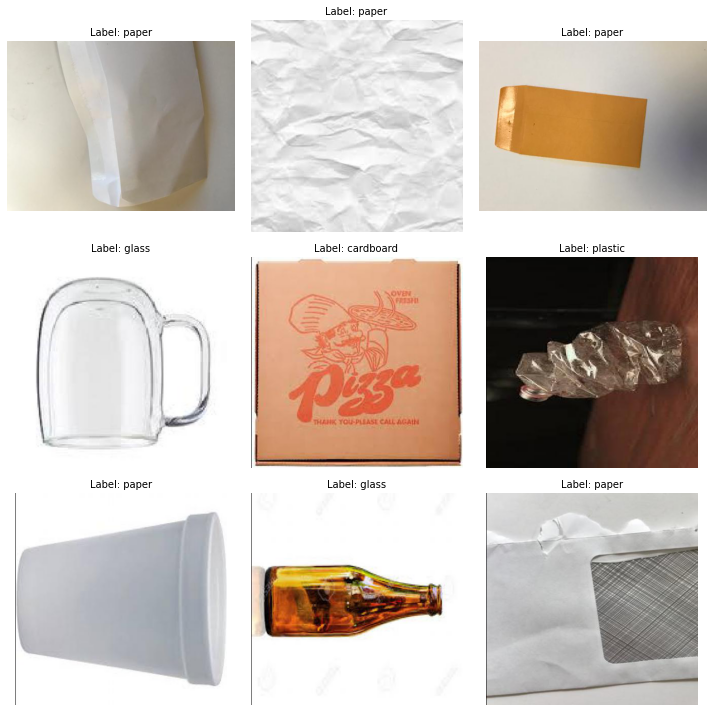

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to display a grid of images
def display_sample_images(df, num_images=9):
    # Create a figure to display the images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Adjust grid size as needed
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Loop through the first `num_images` rows in the DataFrame
    for i, (img_path, label) in enumerate(zip(df['imgPath'][:num_images], df['label'][:num_images])):
        # Open the image using PIL
        img = Image.open(img_path)
        
        # Display the image on the subplot
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}", fontsize=10)
        axes[i].axis('off')  # Turn off axis labels
        
    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to display sample images
display_sample_images(df)

# data augmentation


In [10]:
trainData = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(1.0, 1.2),   # zoom in 
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
)

imgSize= (224,224)

trainGenerator = trainData.flow_from_dataframe(
    trainDf,
    x_col = 'imgPath',
    y_col = 'label',
    target_size =imgSize,
    batch_size=32,
    class_mode = 'categorical'
)

Found 7041 validated image filenames belonging to 6 classes.


In [11]:
testData = ImageDataGenerator(
    rescale=1./255
)


testGenerator = trainData.flow_from_dataframe(
    testDf,
    x_col = 'imgPath',
    y_col = 'label',
    target_size =imgSize,
    batch_size=4,
    class_mode = 'categorical',
    shuffle = False
)

Found 1762 validated image filenames belonging to 6 classes.


# modelling

In [12]:
# # import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam

# # Define the CNN model
# model = Sequential([
#     # Input layer with shape (224, 224, 3)
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 32 filters, kernel size 3x3
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),  # Pooling layer to reduce spatial dimensions

#     Conv2D(64, (3, 3), activation='relu'),  # 64 filters
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     Conv2D(128, (3, 3), activation='relu'),  # 128 filters
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     Conv2D(256, (3, 3), activation='relu'),  # 256 filters
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Flatten the feature maps into a 1D vector
#     Flatten(),

#     # Fully connected (dense) layers
#     Dense(512, activation='relu'),  # Hidden layer with 512 neurons
#     BatchNormalization(),
#     Dropout(0.5),  # Dropout for regularization

#     Dense(128, activation='relu'),  # Hidden layer with 128 neurons
#     BatchNormalization(),
#     Dropout(0.3),

#     # Output layer with softmax activation for multi-class classification
#     Dense(6, activation='softmax')  # Assuming 6 classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


# # Train the model
# history = model.fit(
#     trainGenerator,
#     validation_data=testGenerator,
#     epochs=50,
#     verbose=1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             patience=4,
#             monitor='val_accuracy',
#             restore_best_weights=True
#         )
#     ]
# )

In [13]:
    Model =Sequential([
        MobileNetV2(weights = 'imagenet', include_top=False, input_shape=(224,224,3)),
        Flatten(),
        Dense(64,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.08),
        Dense(6, activation = 'softmax')
    ])

In [14]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [15]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])


In [16]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator, 
                    epochs=50,
#                     batch_size=64,   # we define it above inside trainGenerator
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

C:\Users\Dell\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.7059 - loss: 0.8513 - val_accuracy: 0.8377 - val_loss: 0.4824
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8723 - loss: 0.3685 - val_accuracy: 0.8541 - val_loss: 0.3843
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 219s 992ms/step - accuracy: 0.8923 - loss: 0.3124 - val_accuracy: 0.8723 - val_loss: 0.3602
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.9139 - loss: 0.2484 - val_accuracy: 0.8678 - val_loss: 0.4195
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9254 - loss: 0.2129 - val_accuracy: 0.8961 - val_loss: 0.3093
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 220s 994ms/step - accuracy: 0.9377 - loss: 0.1803 - val_accuracy: 0.9035 - val_loss: 0.3312
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 213s 965ms/step - accuracy: 0.9479 - loss: 0.1561 - val_accuracy: 0.9081 - val_loss: 0.3330
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 213s 965ms/step - accuracy: 0.9559 - loss: 0.135

In [27]:
Model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,014,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,127,700 (57.71 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,854,926 (33.78 MB)

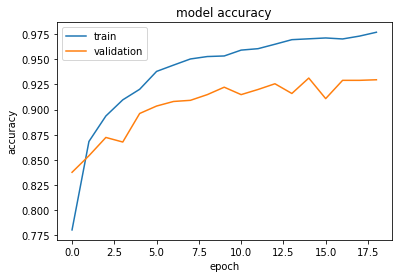

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# using conv2d

# evaluation

In [19]:
predictions = Model.predict(testGenerator)


441/441 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step


In [20]:
trainGenerator.class_indices


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [21]:

trueClasses = testGenerator.classes
trueClasses[:10]

[0, 3, 1, 4, 3, 3, 1, 4, 1, 2]

In [22]:

predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([0, 3, 1, 4, 3, 3, 1, 4, 1, 2], dtype=int64)

In [23]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

441/441 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9357 - loss: 0.2159


0.9330306649208069

# CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [24]:
# ClassificationReport = classification_report(trueClasses, predictedClasses)
# print('Classification Report is : \n', ClassificationReport )

# Image Prediction

In [25]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index
    
    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index
    
    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]
    
    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)
    
    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


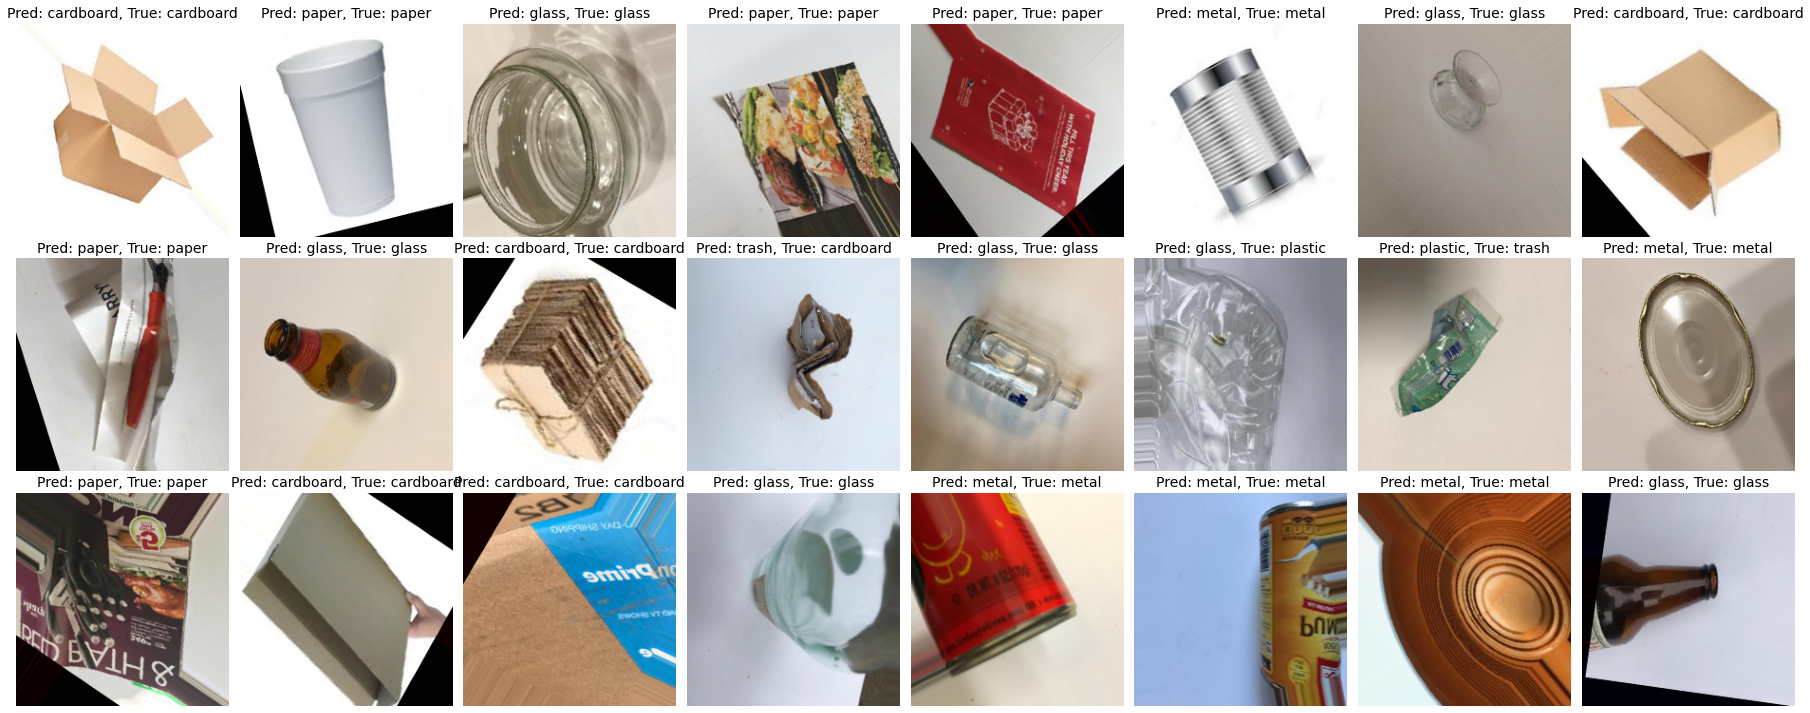

In [26]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')
    
plt.tight_layout()
plt.show()